In [1]:
#Import the libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates


import datetime
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc

import keras
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet import Prophet
from prophet.plot import plot_plotly

In [2]:
import pandas as pd

# Load the data
df_aapl = pd.read_csv('data/AAPL.csv')
df_adbe = pd.read_csv('data/ADBE.csv')
df_amd = pd.read_csv('data/AMD.csv')
df_cmcsa = pd.read_csv('data/CMCSA.csv')
df_cost = pd.read_csv('data/COST.csv')
df_intc = pd.read_csv('data/INTC.csv')
df_intu = pd.read_csv('data/INTU.csv')
df_msft = pd.read_csv('data/MSFT.csv')
df_qcom = pd.read_csv('data/QCOM.csv')
df_sbux = pd.read_csv('data/SBUX.csv')

dfs = [df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)



In [3]:
def remove_before_2005(df):
    df = df[df.index.year >= 2005]
    df.reset_index(inplace=True)
    return df

dfs = [remove_before_2005(df) for df in dfs]

df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux = dfs

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def retrieve_closing_prices_only(data):
    return data[['Close']]

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data.values)
    return scaler, pd.DataFrame(normalized_data, columns=['Close'])


In [5]:

aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(df_aapl))
adbe_scaler, new_adbe_df = min_max_scaling(retrieve_closing_prices_only(df_adbe))
amd_scaler, new_amd_df = min_max_scaling(retrieve_closing_prices_only(df_amd))
cmcsa_scaler, new_cmcsa_df = min_max_scaling(retrieve_closing_prices_only(df_cmcsa))
cost_scaler, new_cost_df = min_max_scaling(retrieve_closing_prices_only(df_cost))
intc_scaler, new_intc_df = min_max_scaling(retrieve_closing_prices_only(df_intc))
intu_scaler, new_intu_df = min_max_scaling(retrieve_closing_prices_only(df_intu))
msft_scaler, new_msft_df = min_max_scaling(retrieve_closing_prices_only(df_msft))
qcom_scaler, new_qcom_df = min_max_scaling(retrieve_closing_prices_only(df_qcom))
sbux_scaler, new_sbux_df = min_max_scaling(retrieve_closing_prices_only(df_sbux))


In [6]:
new_aapl_df.head()

,Close
0,0.000000
1,0.000064
2,0.000119
3,0.000124
4,0.000588


In [7]:
import numpy as np

def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.90))
    test_size = int(np.ceil(len(dataframe) * 0.10))
    
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    data_array = dataframe['Close'].values
    
    train_data = data_array[0: train_size]
    test_data = data_array[train_size - prediction_days: train_size + test_size]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i])
        y_train.append(train_data[i])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i])
        y_test.append(test_data[i])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f'Data for {company.title()} split successfully')
    
    return X_train, y_train, X_test, y_test


In [8]:
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'Apple')
X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe = split_and_reshape_data(new_adbe_df, 30, 'Adobe')
X_train_amd, y_train_amd, X_test_amd, y_test_amd = split_and_reshape_data(new_amd_df, 30, 'AMD')
X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa = split_and_reshape_data(new_cmcsa_df, 30, 'Comcast')
X_train_cost, y_train_cost, X_test_cost, y_test_cost = split_and_reshape_data(new_cost_df, 30, 'Costco')
X_train_intc, y_train_intc, X_test_intc, y_test_intc = split_and_reshape_data(new_intc_df, 30, 'Intel')
X_train_intu, y_train_intu, X_test_intu, y_test_intu = split_and_reshape_data(new_intu_df, 30, 'Intuit')
X_train_msft, y_train_msft, X_test_msft, y_test_msft = split_and_reshape_data(new_msft_df, 30, 'Microsoft')
X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom = split_and_reshape_data(new_qcom_df, 30, 'Qualcomm')
X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux = split_and_reshape_data(new_sbux_df, 30, 'Starbucks')


The training size for Apple is 4067 rows
The testing size for Apple is 452 rows
Data for Apple split successfully
The training size for Adobe is 4067 rows
The testing size for Adobe is 452 rows
Data for Adobe split successfully
The training size for Amd is 4067 rows
The testing size for Amd is 452 rows
Data for Amd split successfully
The training size for Comcast is 4067 rows
The testing size for Comcast is 452 rows
Data for Comcast split successfully
The training size for Costco is 4067 rows
The testing size for Costco is 452 rows
Data for Costco split successfully
The training size for Intel is 4067 rows
The testing size for Intel is 452 rows
Data for Intel split successfully
The training size for Intuit is 4067 rows
The testing size for Intuit is 452 rows
Data for Intuit split successfully
The training size for Microsoft is 4067 rows
The testing size for Microsoft is 452 rows
Data for Microsoft split successfully
The training size for Qualcomm is 4067 rows
The testing size for Qualc

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

# Function to create and train a pure CNN model without pooling
def create_and_train_cnn_model(X_train, y_train, X_test, y_test, company):
    print(f'=========For {company}=========')

    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        
        Conv1D(128, kernel_size=3, activation='relu'),
        Dropout(0.2),
        
        Conv1D(256, kernel_size=3, activation='relu'),
        Dropout(0.2),
        Flatten(),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(), loss=Huber(), metrics=['mse'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])
    
    y_pred = model.predict(X_test)
    
    return model, history, y_pred


=========For Apple=========
Epoch 1/50
127/127 [==============================] - 1s 7ms/step - loss: 7.4673e-04 - mse: 0.0015 - val_loss: 0.0018 - val_mse: 0.0035
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 1.6216e-04 - mse: 3.2433e-04 - val_loss: 0.0036 - val_mse: 0.0071
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 1.7846e-04 - mse: 3.5692e-04 - val_loss: 8.8608e-04 - val_mse: 0.0018
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 1.8519e-04 - mse: 3.7038e-04 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 1.9332e-04 - mse: 3.8664e-04 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 6/50
15/15 [==============================] - 0s 1ms/step
The MSE for Apple with CNN is 0.0017721676954357618


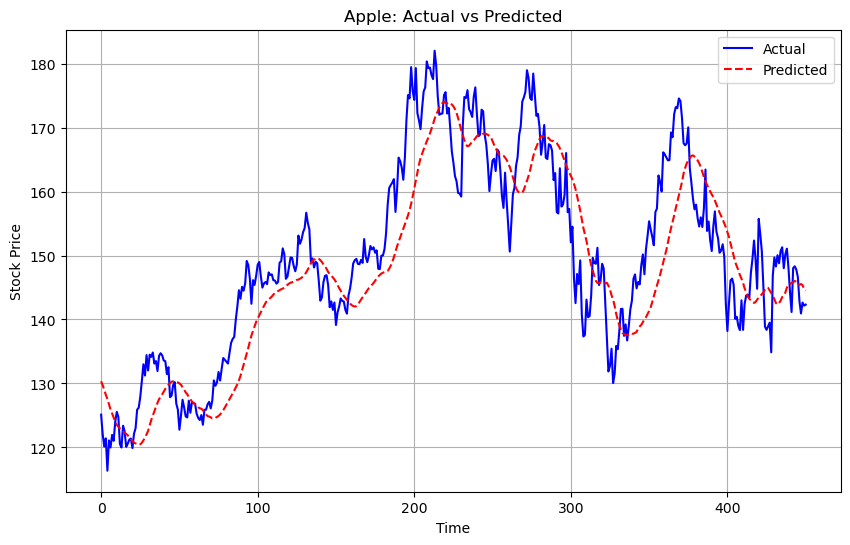

=========For Adobe=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 7.4648e-04 - mse: 0.0015 - val_loss: 0.0075 - val_mse: 0.0150
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 1.8322e-04 - mse: 3.6644e-04 - val_loss: 0.0071 - val_mse: 0.0142
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 1.9269e-04 - mse: 3.8537e-04 - val_loss: 0.0114 - val_mse: 0.0228
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 2.1299e-04 - mse: 4.2597e-04 - val_loss: 0.0021 - val_mse: 0.0043
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 1.7255e-04 - mse: 3.4511e-04 - val_loss: 0.0059 - val_mse: 0.0119
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: 1.4213e-04 - mse: 2.8426e-04 - val_loss: 0.0150 - val_mse: 0.0300
Epoch 7/50
15/15 [==============================] - 0s 2ms/step
The MSE for Adobe with CNN is 0.004254269533974879


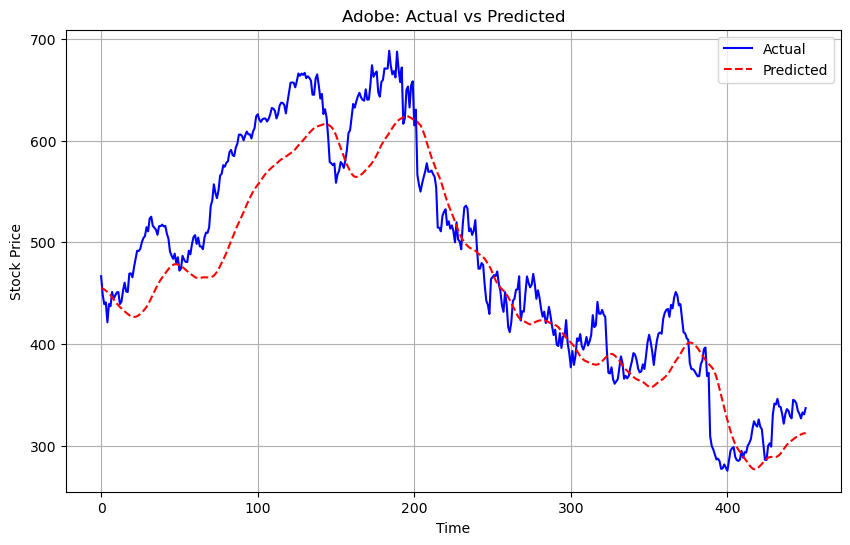

=========For AMD=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 2.8870e-04 - mse: 5.7739e-04 - val_loss: 0.0053 - val_mse: 0.0106
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 2.7673e-04 - mse: 5.5345e-04 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 1.6660e-04 - mse: 3.3320e-04 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 1.5727e-04 - mse: 3.1454e-04 - val_loss: 0.0029 - val_mse: 0.0057
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 1.3147e-04 - mse: 2.6294e-04 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: 1.4228e-04 - mse: 2.8456e-04 - val_loss: 0.0033 - val_mse: 0.0067
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: 1.6047e-04 - mse: 3.2095e-04 - val_loss: 0.0011 - val_mse: 0

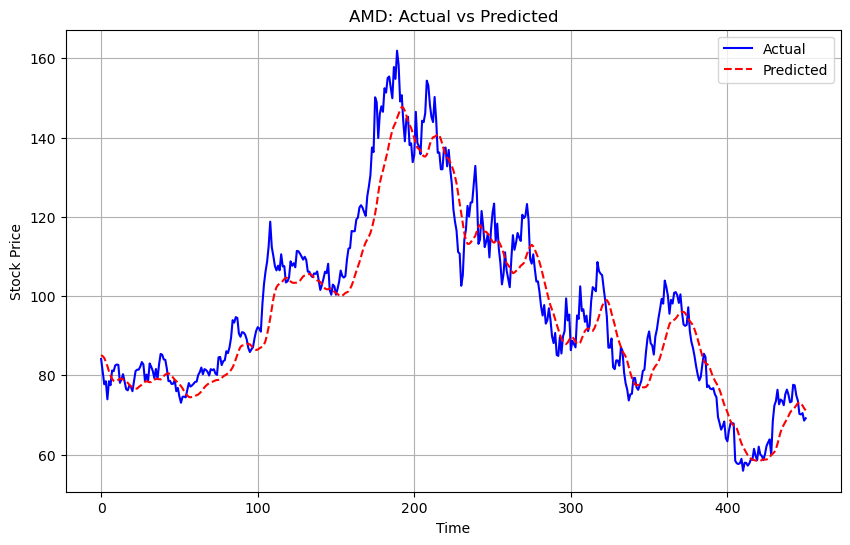

=========For Comcast=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 4.0619e-04 - mse: 8.1239e-04 - val_loss: 0.0091 - val_mse: 0.0182
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 3.4966e-04 - mse: 6.9933e-04 - val_loss: 0.0073 - val_mse: 0.0146
Epoch 4/50
15/15 [==============================] - 0s 1ms/step
The MSE for Comcast with CNN is 0.003305625154391562


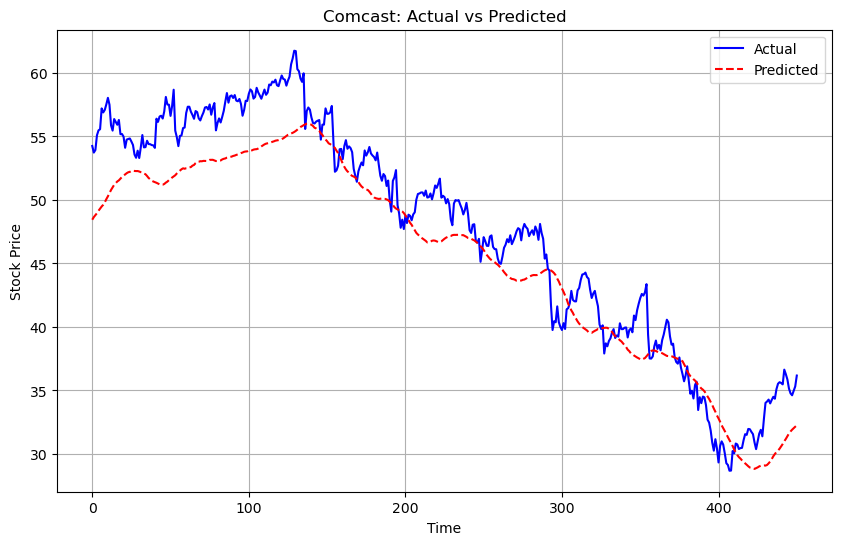

=========For Costco=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 7.4284e-04 - mse: 0.0015 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 1.1679e-04 - mse: 2.3358e-04 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 9.8303e-05 - mse: 1.9661e-04 - val_loss: 0.0056 - val_mse: 0.0112
Epoch 4/50
15/15 [==============================] - 0s 1ms/step
The MSE for Costco with CNN is 0.004779031119736299


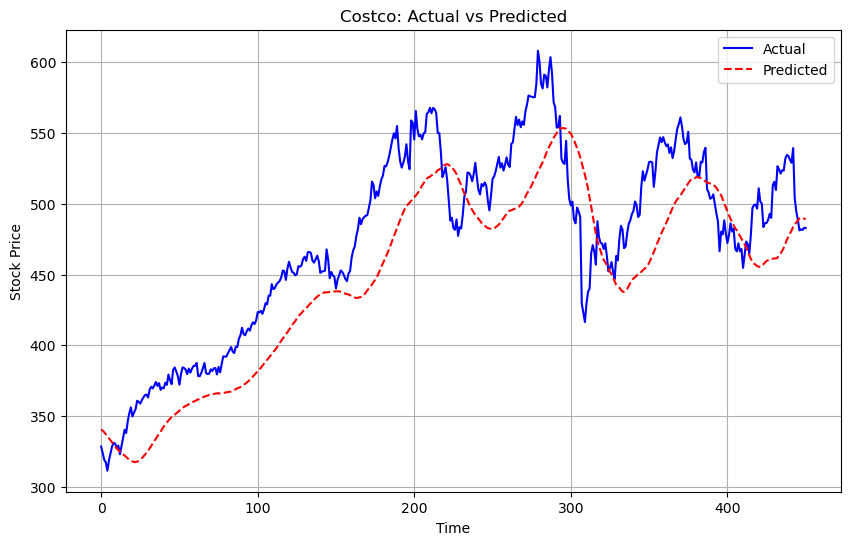

=========For Intel=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 0.0024 - mse: 0.0048 - val_loss: 0.0021 - val_mse: 0.0042
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 8.6288e-04 - mse: 0.0017 - val_loss: 7.6950e-04 - val_mse: 0.0015
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 7.6561e-04 - mse: 0.0015 - val_loss: 0.0033 - val_mse: 0.0067
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 8.5324e-04 - mse: 0.0017 - val_loss: 0.0029 - val_mse: 0.0058
Epoch 5/50
15/15 [==============================] - 0s 1ms/step
The MSE for Intel with CNN is 0.0015389945185257405


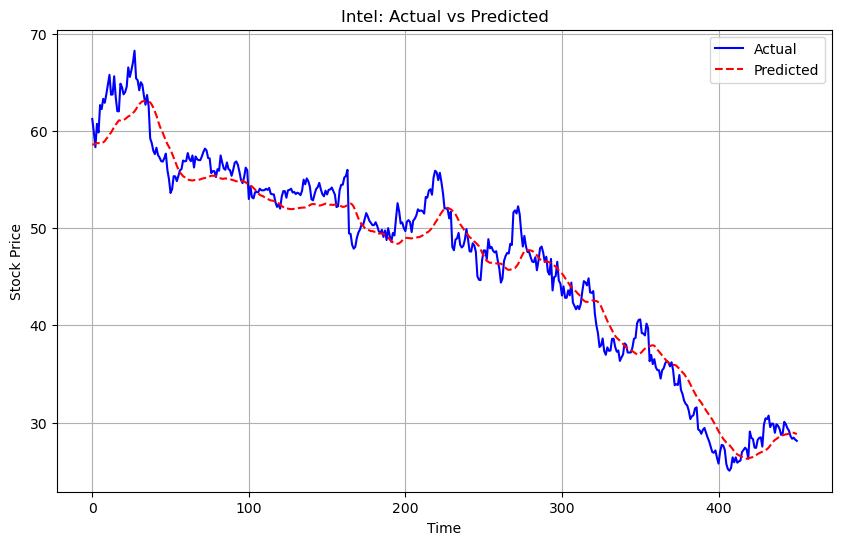

=========For Intuit=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 5.2550e-04 - mse: 0.0011 - val_loss: 0.0045 - val_mse: 0.0091
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 1.3207e-04 - mse: 2.6414e-04 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 1.3546e-04 - mse: 2.7093e-04 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 8.7972e-05 - mse: 1.7594e-04 - val_loss: 0.0031 - val_mse: 0.0061
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 1.3412e-04 - mse: 2.6824e-04 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: 1.1138e-04 - mse: 2.2276e-04 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: 1.0667e-04 - mse: 2.1335e-04 - val_loss: 0.0046 - val_mse: 0.

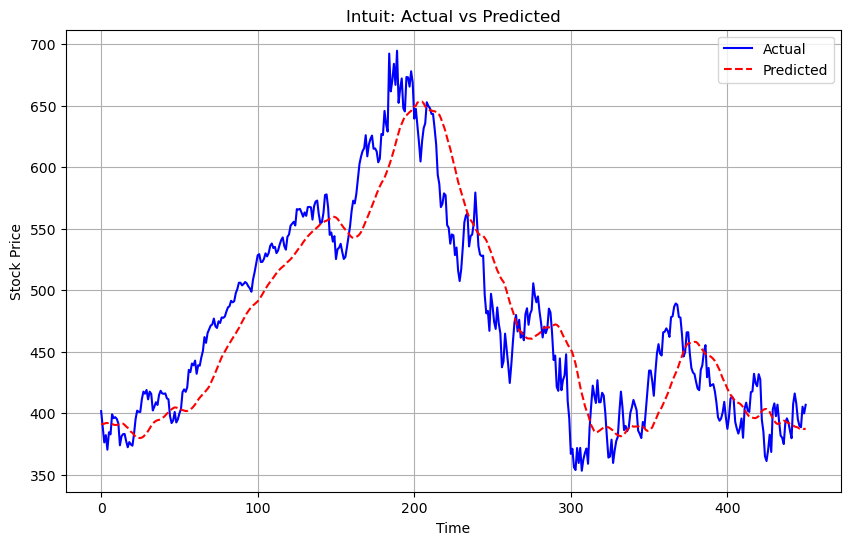

=========For Microsoft=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 5.1299e-04 - mse: 0.0010 - val_loss: 0.0073 - val_mse: 0.0145
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 1.5016e-04 - mse: 3.0031e-04 - val_loss: 0.0110 - val_mse: 0.0220
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 1.8216e-04 - mse: 3.6431e-04 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 1.7009e-04 - mse: 3.4018e-04 - val_loss: 0.0203 - val_mse: 0.0406
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 1.5844e-04 - mse: 3.1689e-04 - val_loss: 0.0056 - val_mse: 0.0111
Epoch 6/50
15/15 [==============================] - 0s 1ms/step
The MSE for Microsoft with CNN is 0.0029508270753515016


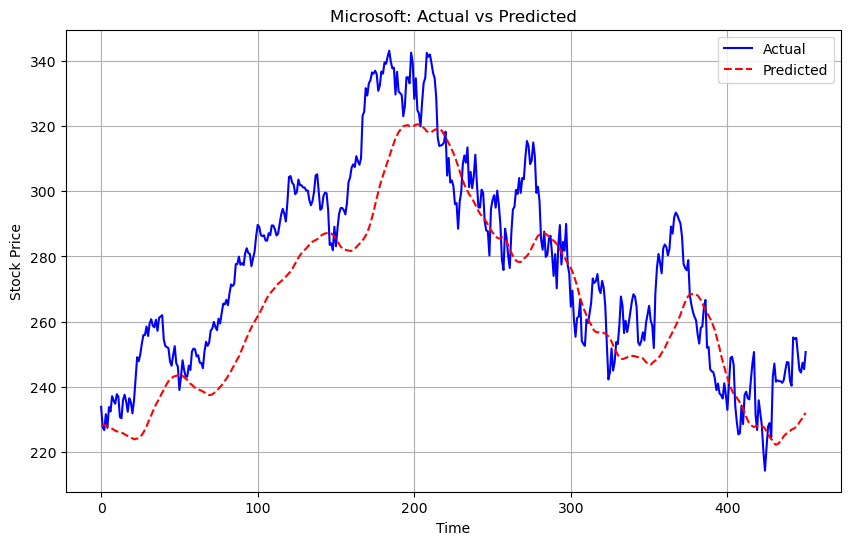

=========For Qualcomm=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 3.5332e-04 - mse: 7.0664e-04 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 4.0716e-04 - mse: 8.1433e-04 - val_loss: 0.0051 - val_mse: 0.0102
Epoch 4/50
15/15 [==============================] - 0s 1ms/step
The MSE for Qualcomm with CNN is 0.0037533117877522207


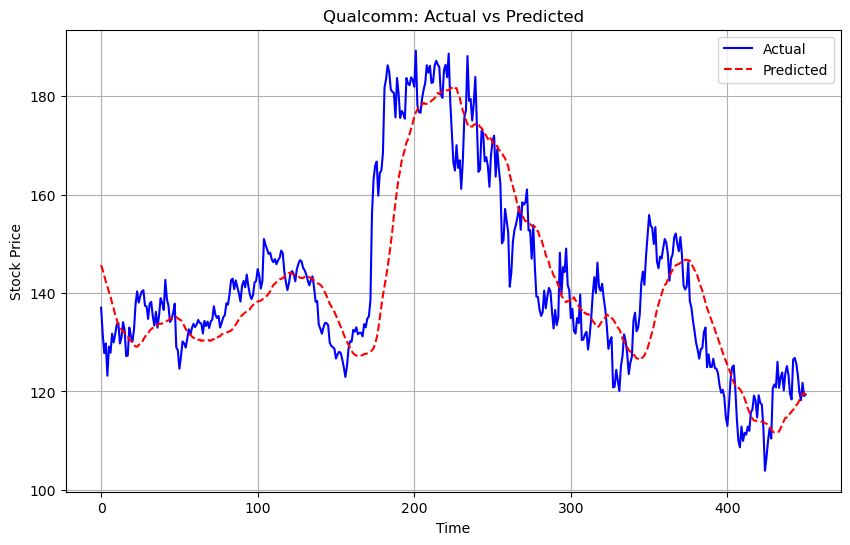

=========For Starbucks=========
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 2/50
127/127 [==============================] - 1s 5ms/step - loss: 3.3864e-04 - mse: 6.7728e-04 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: 3.1769e-04 - mse: 6.3538e-04 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: 2.8467e-04 - mse: 5.6935e-04 - val_loss: 0.0070 - val_mse: 0.0141
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: 3.2469e-04 - mse: 6.4938e-04 - val_loss: 0.0041 - val_mse: 0.0082
Epoch 6/50
15/15 [==============================] - 0s 1ms/step
The MSE for Starbucks with CNN is 0.003316324760171049


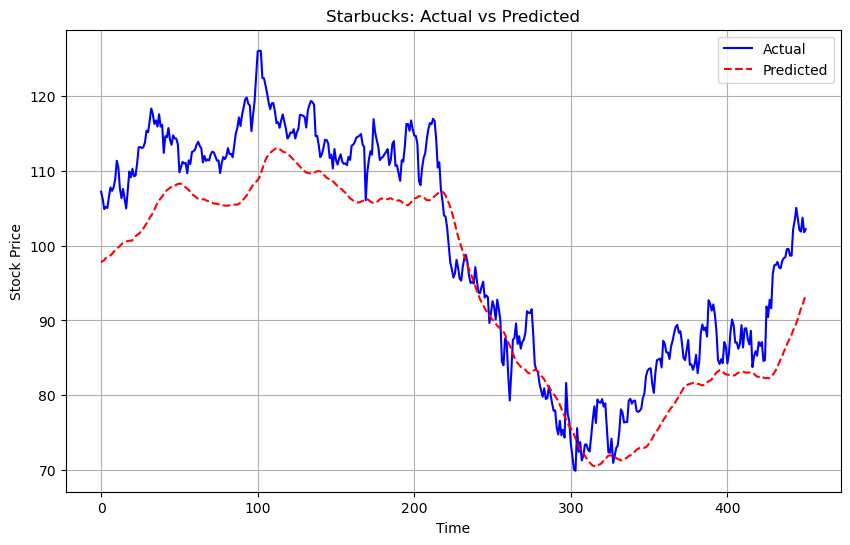


Aggregate MSE for CNN models across all stocks:  0.003019161561385985

Mean MSE for CNN model:  0.003019161561385985


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to plot predictions vs actual values with inverse scaling
def plot_predictions_vs_truth(y_test, y_pred, company_name, scaler):
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'{company_name}: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def predictions_cnn_mse(company, model, X_test, y_test, scaler):
    global mse_cnn
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_cnn += mse
    
    print(f'The MSE for {company} with CNN is {mse}')
    
    plot_predictions_vs_truth(y_test, y_pred, company, scaler)
    
    return y_pred, y_test, mse

cnn_models = {}
cnn_predictions = {}
mse_cnn = 0
mse_list = []

scalers = {
    'Apple': aapl_scaler,
    'Adobe': adbe_scaler,
    'AMD': amd_scaler,
    'Comcast': cmcsa_scaler,
    'Costco': cost_scaler,
    'Intel': intc_scaler,
    'Intuit': intu_scaler,
    'Microsoft': msft_scaler,
    'Qualcomm': qcom_scaler,
    'Starbucks': sbux_scaler
}

cnn_models['Apple'], _, cnn_predictions['Apple'] = create_and_train_cnn_model(X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl, 'Apple')
y_pred_aapl, y_test_aapl, mse_aapl = predictions_cnn_mse('Apple', cnn_models['Apple'], X_test_aapl, y_test_aapl, scalers['Apple'])
mse_list.append(mse_aapl)

cnn_models['Adobe'], _, cnn_predictions['Adobe'] = create_and_train_cnn_model(X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe, 'Adobe')
y_pred_adbe, y_test_adbe, mse_adbe = predictions_cnn_mse('Adobe', cnn_models['Adobe'], X_test_adbe, y_test_adbe, scalers['Adobe'])
mse_list.append(mse_adbe)

cnn_models['AMD'], _, cnn_predictions['AMD'] = create_and_train_cnn_model(X_train_amd, y_train_amd, X_test_amd, y_test_amd, 'AMD')
y_pred_amd, y_test_amd, mse_amd = predictions_cnn_mse('AMD', cnn_models['AMD'], X_test_amd, y_test_amd, scalers['AMD'])
mse_list.append(mse_amd)

cnn_models['Comcast'], _, cnn_predictions['Comcast'] = create_and_train_cnn_model(X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa, 'Comcast')
y_pred_cmcsa, y_test_cmcsa, mse_cmcsa = predictions_cnn_mse('Comcast', cnn_models['Comcast'], X_test_cmcsa, y_test_cmcsa, scalers['Comcast'])
mse_list.append(mse_cmcsa)

cnn_models['Costco'], _, cnn_predictions['Costco'] = create_and_train_cnn_model(X_train_cost, y_train_cost, X_test_cost, y_test_cost, 'Costco')
y_pred_cost, y_test_cost, mse_cost = predictions_cnn_mse('Costco', cnn_models['Costco'], X_test_cost, y_test_cost, scalers['Costco'])
mse_list.append(mse_cost)

cnn_models['Intel'], _, cnn_predictions['Intel'] = create_and_train_cnn_model(X_train_intc, y_train_intc, X_test_intc, y_test_intc, 'Intel')
y_pred_intc, y_test_intc, mse_intc = predictions_cnn_mse('Intel', cnn_models['Intel'], X_test_intc, y_test_intc, scalers['Intel'])
mse_list.append(mse_intc)

cnn_models['Intuit'], _, cnn_predictions['Intuit'] = create_and_train_cnn_model(X_train_intu, y_train_intu, X_test_intu, y_test_intu, 'Intuit')
y_pred_intu, y_test_intu, mse_intu = predictions_cnn_mse('Intuit', cnn_models['Intuit'], X_test_intu, y_test_intu, scalers['Intuit'])
mse_list.append(mse_intu)

cnn_models['Microsoft'], _, cnn_predictions['Microsoft'] = create_and_train_cnn_model(X_train_msft, y_train_msft, X_test_msft, y_test_msft, 'Microsoft')
y_pred_msft, y_test_msft, mse_msft = predictions_cnn_mse('Microsoft', cnn_models['Microsoft'], X_test_msft, y_test_msft, scalers['Microsoft'])
mse_list.append(mse_msft)

cnn_models['Qualcomm'], _, cnn_predictions['Qualcomm'] = create_and_train_cnn_model(X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom, 'Qualcomm')
y_pred_qcom, y_test_qcom, mse_qcom = predictions_cnn_mse('Qualcomm', cnn_models['Qualcomm'], X_test_qcom, y_test_qcom, scalers['Qualcomm'])
mse_list.append(mse_qcom)

cnn_models['Starbucks'], _, cnn_predictions['Starbucks'] = create_and_train_cnn_model(X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux, 'Starbucks')
y_pred_sbux, y_test_sbux, mse_sbux = predictions_cnn_mse('Starbucks', cnn_models['Starbucks'], X_test_sbux, y_test_sbux, scalers['Starbucks'])
mse_list.append(mse_sbux)

mean_mse_cnn = mse_cnn / len(cnn_models)
print("\nAggregate MSE for CNN models across all stocks: ", mean_mse_cnn)

mse_dense = mean_mse_cnn
print("\nMean MSE for CNN model: ", mse_dense)


In [14]:
mse_cnn=mse_cnn/10

In [15]:
mse_cnn

0.003019161561385985

In [16]:
mse_list
mse_results_cnn=mse_list

In [17]:
import pickle

# Save the mse_results dictionary and mse_cnn value to a file
with open('mse_results_and_cnn.pkl', 'wb') as file:
    pickle.dump({'mse_results_cnn': mse_results_cnn, 'mse_cnn': mse_cnn}, file)

print("mse_results_cnn and mse_cnn have been saved to mse_results_and_cnn.pkl")

mse_results_cnn and mse_cnn have been saved to mse_results_and_cnn.pkl
